<img src="https://raw.githubusercontent.com/jmsr06/CancerCervical/master/fondo2.jpg" tite="Inteligencia Artificial en la medicina" style="width:900px; height:auto; align-text:center" alt="Algoritmos de Machine learning y Deep learning para la predicción de la realización biopsia"/>

#<h1>Factores de riesgo que llevan a realizar una biopsia para detectar cáncer de cuello uterino</h1>

In [185]:
#@title MONTAR EL DRIVE { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/proyecto-IA')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/proyecto-IA


In [50]:
#!pip install imblearn
#!pip install -U imbalanced-learn
!pip install imbalanced-learn

In [52]:
#@title  CARGAR LIBRERÍAS { display-mode: "form" }
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import * 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure


from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
#from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
#from scipy import stats
from imblearn.under_sampling import NearMiss
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedBaggingClassifier

## 1. Observación de los datos

In [224]:
d = pd.read_csv("data/risk_factors_cervical_cancer.csv") #original
db = pd.read_csv("data/cancer_cervical.csv") #tiene mas
print("tamaño: ",d.shape)
d.head()

tamaño:  (858, 36)


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0


In [225]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

Parece que faltan algunos valores denominados '?', E hicieron que toda la columna se convirtiera en un objeto. Para hacer más cálculos, tenemos que reemplazar '?' con NaN y cambiar el tipo de objeto a tipo numérico.

In [226]:
d= d.replace('?', np.nan)
d.isnull().sum() 

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

## 2. Procesamiento de Datos

In [227]:
df = d
#convertimos todas las columnas a tipo flotante
for i in df.columns:
  df[i]=df[i].astype(float)
#df = df.convert_dtypes() #convertimos las columnas al mejor tipo que lo representa

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    float64
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

observamos que las dos columnas 'STDs: Time since first diagnosis' y'STDs: Time since last diagnosis' sólo tienen 71 datos de 858 no nulos, por lo tanto la mayoría de los datos se perdieron y procedemos a eliminar esta columna

In [229]:
df = df.drop(['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], axis=1)

In [230]:
#@title Llenar los datos NAN { display-mode: "form" }
# for continuous variable
df['Number of sexual partners'] = df['Number of sexual partners'].fillna(df['Number of sexual partners'].median())
df['First sexual intercourse'] = df['First sexual intercourse'].fillna(df['First sexual intercourse'].median())
df['Num of pregnancies'] = df['Num of pregnancies'].fillna(df['Num of pregnancies'].median())

df['Smokes'] = df['Smokes'].fillna(0)#por sugerencia
df['Smokes (years)'] = df['Smokes (years)'].fillna(0)
df['Smokes (packs/year)'] = df['Smokes (packs/year)'].fillna(0)

df['Hormonal Contraceptives'] = df['Hormonal Contraceptives'].fillna(1)#por sugerencia
df['Hormonal Contraceptives (years)'] = df['Hormonal Contraceptives (years)'].fillna(df['Hormonal Contraceptives (years)'].mean())

df['IUD'] = df['IUD'].fillna(0) # bajo sugerencia
df['IUD (years)'] = df['IUD (years)'].fillna(0) #bajo sugerencia

df['STDs'] = df['STDs'].fillna(1)#v
df['STDs (number)'] = df['STDs (number)'].fillna(df['STDs (number)'].median())
df['STDs:condylomatosis'] = df['STDs:condylomatosis'].fillna(df['STDs:condylomatosis'].median())
df['STDs:cervical condylomatosis'] = df['STDs:cervical condylomatosis'].fillna(df['STDs:cervical condylomatosis'].median())
df['STDs:vaginal condylomatosis'] = df['STDs:vaginal condylomatosis'].fillna(df['STDs:vaginal condylomatosis'].median())
df['STDs:vulvo-perineal condylomatosis'] = df['STDs:vulvo-perineal condylomatosis'].fillna(df['STDs:vulvo-perineal condylomatosis'].median())
df['STDs:syphilis'] = df['STDs:syphilis'].fillna(df['STDs:syphilis'].median())
df['STDs:pelvic inflammatory disease'] = df['STDs:pelvic inflammatory disease'].fillna(df['STDs:pelvic inflammatory disease'].median())
df['STDs:genital herpes'] = df['STDs:genital herpes'].fillna(df['STDs:genital herpes'].median())
df['STDs:molluscum contagiosum'] = df['STDs:molluscum contagiosum'].fillna(df['STDs:molluscum contagiosum'].median())
df['STDs:AIDS'] = df['STDs:AIDS'].fillna(df['STDs:AIDS'].median())
df['STDs:HIV'] = df['STDs:HIV'].fillna(df['STDs:HIV'].median())
df['STDs:Hepatitis B'] = df['STDs:Hepatitis B'].fillna(df['STDs:Hepatitis B'].median())
df['STDs:HPV'] = df['STDs:HPV'].fillna(df['STDs:HPV'].median())

In [231]:
df.isnull().sum()

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


## 3. Visualización de los datos

In [263]:
df_data = df
#df_data = pd.get_dummies(data=df_data, columns=['Smokes','Hormonal Contraceptives','IUD','STDs',
                                      #'Dx:Cancer','Dx:CIN','Dx:HPV','Dx','Hinselmann','Citology','Schiller'])

In [233]:
df_data.describe()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Biopsy,Smokes_0.0,Smokes_1.0,Hormonal Contraceptives_0.0,Hormonal Contraceptives_1.0,IUD_0.0,IUD_1.0,STDs_0.0,STDs_1.0,Dx:Cancer_0.0,Dx:Cancer_1.0,Dx:CIN_0.0,Dx:CIN_1.0,Dx:HPV_0.0,Dx:HPV_1.0,Dx_0.0,Dx_1.0,Hinselmann_0.0,Hinselmann_1.0,Citology_0.0,Citology_1.0,Schiller_0.0,Schiller_1.0
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.0,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.0,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,2.511655,16.995338,2.257576,1.201241,0.446278,2.256419,0.444604,0.155012,0.051282,0.0,0.004662,0.050117,0.020979,0.001166,0.001166,0.001166,0.0,0.020979,0.001166,0.002331,0.087413,0.064103,0.856643,0.143357,0.313520,0.686480,0.903263,0.096737,0.785548,0.214452,0.979021,0.020979,0.989510,0.010490,0.979021,0.020979,0.972028,0.027972,0.959207,0.040793,0.948718,0.051282,0.913753,0.086247
std,8.497948,1.644759,2.791883,1.400981,4.060623,2.210351,3.519082,1.814218,0.529617,0.220701,0.0,0.068159,0.218313,0.143398,0.034139,0.034139,0.034139,0.0,0.143398,0.034139,0.048252,0.302545,0.245078,0.350641,0.350641,0.464194,0.464194,0.295771,0.295771,0.410681,0.410681,0.143398,0.143398,0.101939,0.101939,0.143398,0.143398,0.164989,0.164989,0.197925,0.197925,0.220701,0.220701,0.280892,0.280892
min,13.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,2.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,25.000000,2.000000,17.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,32.000000,3.000000,18.000000,3.000000,0.000000,0.000000,2.256419,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,84.000000,28.000000,32.000000,11.000000,37.000000,37.000000,30.000000,19.000000,4.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1

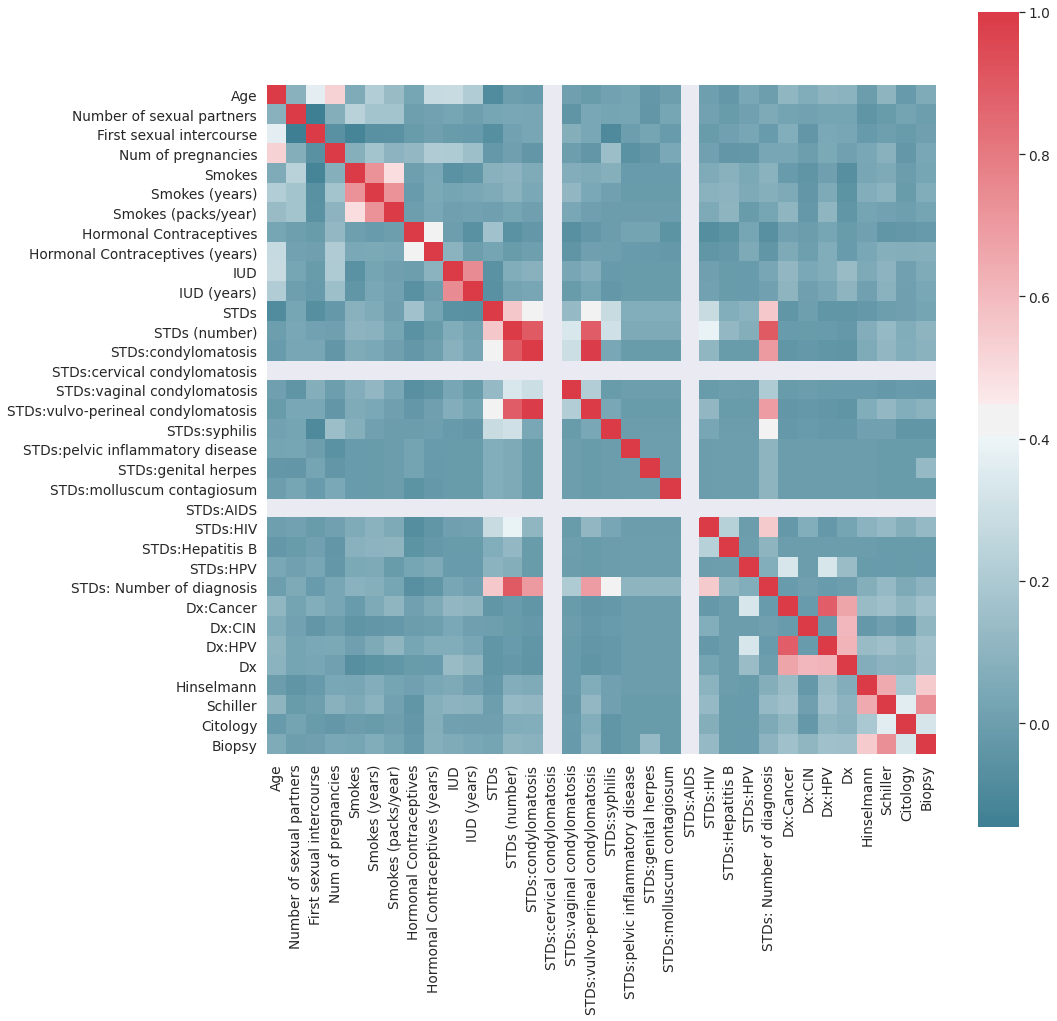

In [264]:
#@title Correlación de los datos { display-mode: "form" }
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 15))
corr = df_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

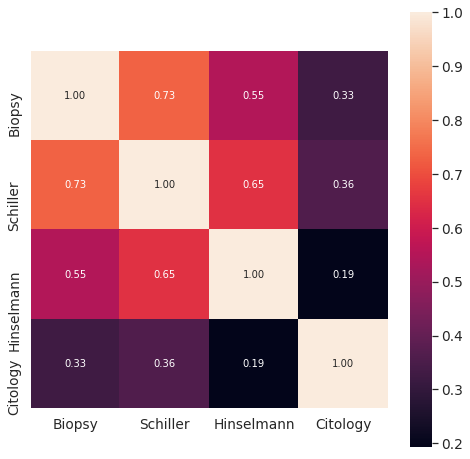

In [267]:
#@title Datos más correlacionados con Biopsia { display-mode: "form" }
k = 4 #number of variables for heatmap
cols = corr.nlargest(k, 'Biopsy')['Biopsy'].index
cm = np.corrcoef(df[cols].values.T)

plt.figure(figsize=(8,8)) 

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels = cols.values, xticklabels = cols.values)
plt.show()

## 4. Datos de entrenamiento y test

In [281]:
np.random.seed(42)
#data = np.random.permutation(df_data.values)
#data = df_data.values
#X = data[:,:-1]
#y = data[:,-1]
df_data_shuffle = df_data.iloc[np.random.permutation(len(df_data))]
X = df_data_shuffle.drop('Biopsy', axis=1).values
y = df_data_shuffle["Biopsy"].values
print ("Distribución de etiquetas de clase antes del remuestreo {}".format(Counter(y)))

Distribución de etiquetas de clase antes del remuestreo Counter({0.0: 803, 1.0: 55})


In [282]:
#@title Funciones { display-mode: "form" }
target= np.unique(y)
def run_model_MC(est, xtrain, xtest, ytrain, ytest,kfold=10):
  est.fit(xtrain,ytrain)
  ypredict = est.predict(xtest)
  score=cross_val_score(est,xtest,ytest,cv=KFold(kfold,shuffle=True),scoring=make_scorer(accuracy_score))
  return est, ypredict, np.mean(score)

def matriz_confusion(ytest, ypredict):
    conf_matrix = confusion_matrix(ytest, ypredict)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, xticklabels=target, yticklabels=target, annot=True, fmt="d");
    plt.title("Matriz de confusión")
    plt.ylabel('Clase verdadera')
    plt.xlabel('Clase predicha')
    plt.show()
    print (classification_report(ytest, ypredict))
    return None

def show_curve(est,Xtest,ytest):
    means, stds = [], []
    nfolds_range = range(2,20)
    for nfolds in nfolds_range:
        #print (nfolds,)
        s = cross_val_score(est, Xtest, ytest, cv=KFold(nfolds, shuffle=True), scoring=make_scorer(accuracy_score))
        means.append(np.mean(s))
        stds.append(np.std(s))

    means = np.r_[means]
    stds  = np.r_[stds]

    plt.plot(nfolds_range, means, label="mean", color="black")
    plt.fill_between(nfolds_range, means-stds, means+stds, color="blue", alpha=.5, label="std")
    plt.xlabel("n folds")
    plt.ylabel("accuracy")
    plt.legend()

def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

#Objetar la sobremuestra de las clases minoritarias seleccionando muestras al azar con reemplazo.
def SobremuestreoAleatorio(X,y,estrategia):
  os =  RandomOverSampler(sampling_strategy=estrategia)
  X, y = os.fit_sample(X, y)
  return X,y

def submuestreo(Xtrain,ytrain):
  us = NearMiss(sampling_strategy='auto', n_neighbors=3, version=2, random_state=1)
  Xtrain, ytrain = us.fit_sample(Xtrain, ytrain)
  return Xtrain, ytrain

def remuestreo_Smote_Tomek(X,y):
  os_us = SMOTETomek(ratio=0.5)
  X, y = os_us.fit_sample(X, y)
  return X,y

def sobremuestreoSMOTe(X,y):
  smote=SMOTE()
  X, y = smote.fit_sample(X,y)
  return X,y

def escalarDatos(X):
  X = StandardScaler().fit_transform(X)
  return X

def aplicarPCA(X,nCompo=7):
  pca = PCA(n_components=nCompo)
  X = pca.fit_transform(X)
  return X


In [283]:
X1 = escalarDatos(X)
X1 = aplicarPCA(X1,.8)

## 5. Diferentes predictores con la clase desbalanceada y con ajuste de parámetros

In [284]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X1,y, test_size=.2)

dimension del dataset:  (858, 34) 

0.0    803
1.0     55
Name: Biopsy, dtype: int64


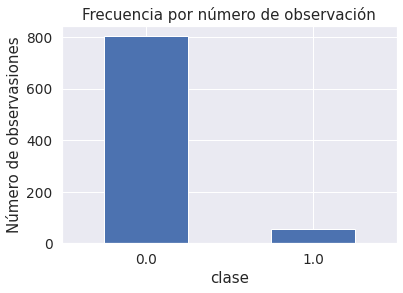

In [285]:
#@title Balance de clases { display-mode: "form" }
print("dimension del dataset: ",df_data.shape,"\n")
print(pd.value_counts(df_data['Biopsy'], sort = True))

count_classes = pd.value_counts(df_data['Biopsy'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2),target)
plt.title("Frecuencia por número de observación")
plt.xlabel("clase")
plt.ylabel("Número de observasiones");

Predictor: GaussianNB
Score en el cross_val_score:  0.9470588235294117
Score en test:  0.9127906976744186
Score en entrenamiento 0.9285714285714286


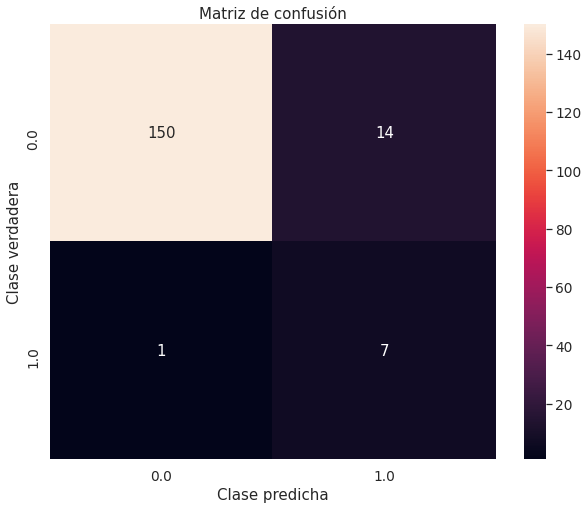

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95       164
         1.0       0.33      0.88      0.48         8

    accuracy                           0.91       172
   macro avg       0.66      0.89      0.72       172
weighted avg       0.96      0.91      0.93       172




Predictor: DecisionTreeClassifier
Score en el cross_val_score:  0.9705882352941178
Score en test:  0.9302325581395349
Score en entrenamiento 0.9810495626822158


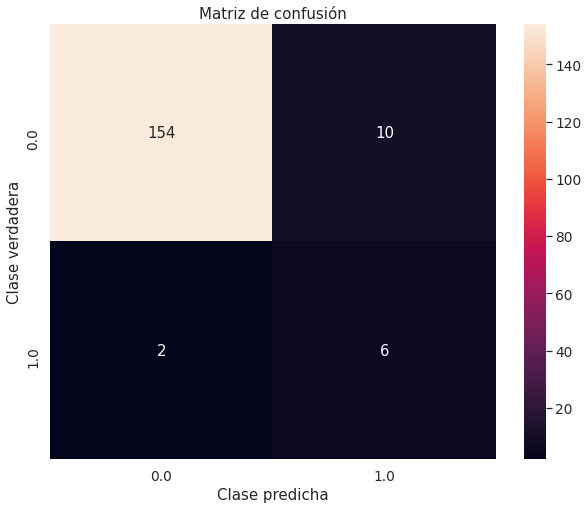

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96       164
         1.0       0.38      0.75      0.50         8

    accuracy                           0.93       172
   macro avg       0.68      0.84      0.73       172
weighted avg       0.96      0.93      0.94       172




Predictor: RandomForestClassifier
Score en el cross_val_score:  0.9653594771241831
Score en test:  0.9476744186046512
Score en entrenamiento 0.9941690962099126


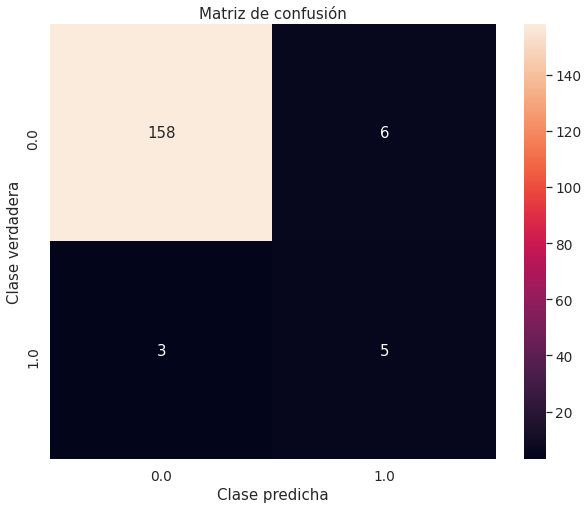

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       164
         1.0       0.45      0.62      0.53         8

    accuracy                           0.95       172
   macro avg       0.72      0.79      0.75       172
weighted avg       0.96      0.95      0.95       172




Predictor: SVC
Score en el cross_val_score:  0.9303921568627451
Score en test:  0.9418604651162791
Score en entrenamiento 0.9475218658892128


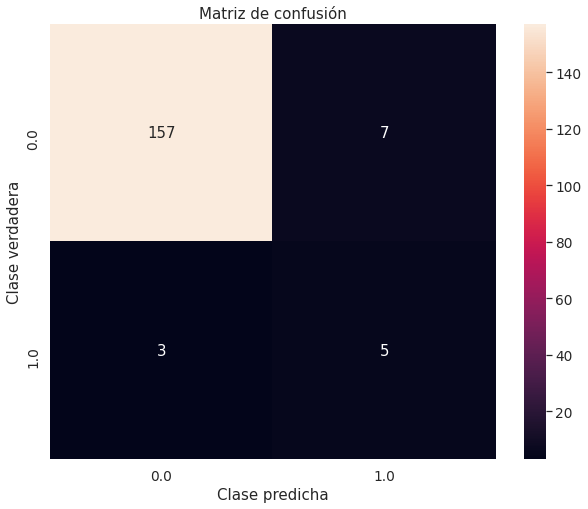

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       164
         1.0       0.42      0.62      0.50         8

    accuracy                           0.94       172
   macro avg       0.70      0.79      0.73       172
weighted avg       0.95      0.94      0.95       172






In [286]:
#@title Pruebas con los clasificadores { display-mode: "form" }
NB = GaussianNB() 
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced")
RF = RandomForestClassifier(n_estimators=64,max_depth=7,criterion="gini",class_weight="balanced")
SV= SVC(kernel='rbf',degree=3,gamma="scale",cache_size=300,class_weight="balanced")
predictores = ['GaussianNB','DecisionTreeClassifier','RandomForestClassifier','SVC']
PDs = [NB,DT,RF,SV]
scores = []
predict = []
for i,j in enumerate(PDs):
  PD,predic,score = run_model_MC(j,Xtrain,Xtest,ytrain,ytest,10)
  PDs[i] = PD
  predict.append(predic)
  scores.append(score)
  print("Predictor: {}".format(predictores[i]))
  print("Score en el cross_val_score: ",score)
  print("Score en test: ",PD.score(Xtest,ytest))
  print("Score en entrenamiento",PD.score(Xtrain,ytrain))
  matriz_confusion(ytest, predic)
  print("\n\n")


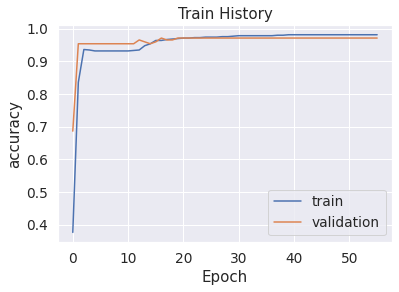

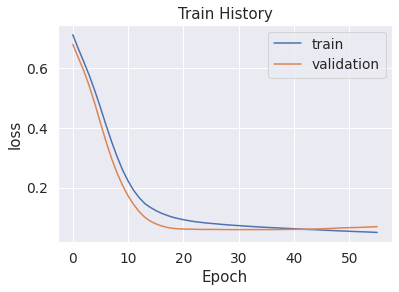

Test accuracy: 0.9709302186965942  test_loss:  0.06886407732963562


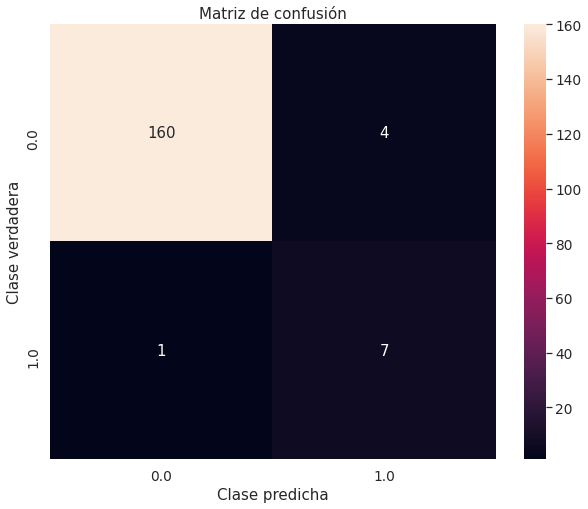

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       164
         1.0       0.64      0.88      0.74         8

    accuracy                           0.97       172
   macro avg       0.82      0.93      0.86       172
weighted avg       0.98      0.97      0.97       172



In [287]:
#@title Modelo de deep learning { display-mode: "form" }
y_train_ohe = tf.keras.utils.to_categorical(ytrain, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(ytest, num_classes=2)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= Xtrain[0].shape),
    tf.keras.layers.Dense(33, activation=tf.nn.relu),
    tf.keras.layers.Dense(28, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
#model.fit(Xtrain_pca, y_train_ohe, epochs=64,batch_size=100, validation_data=(Xtest_pca, y_test_ohe))
train_history = model.fit(x=Xtrain, y=y_train_ohe,  
                          validation_split=0, epochs=56, 
                          batch_size=172, verbose=0,validation_data=(Xtest, y_test_ohe)) 

#visualización de loss y accuracy por cada epoch
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

test_loss, test_acc = model.evaluate(Xtest, y_test_ohe, verbose=False)
print( 'Test accuracy:', test_acc, " test_loss: ", test_loss)
predictions = model.predict_classes(Xtest)
matriz_confusion(ytest, predictions)


## 6. Balanceando las clases

In [288]:
X2,y1 = SobremuestreoAleatorio(X1,y,.5)
print ("Distribución de etiquetas de clase después del sobremuestreo {}".format(Counter(y1)))

Distribución de etiquetas de clase después del sobremuestreo Counter({0.0: 803, 1.0: 401})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [289]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X2,y1, test_size=.2)

In [290]:
print ("Distribución de etiquetas de clase para entrenamiento {}".format(Counter(ytrain)))
print ("Distribución de etiquetas de clase para test {}".format(Counter(ytest)))

Distribución de etiquetas de clase para entrenamiento Counter({0.0: 640, 1.0: 323})
Distribución de etiquetas de clase para test Counter({0.0: 163, 1.0: 78})


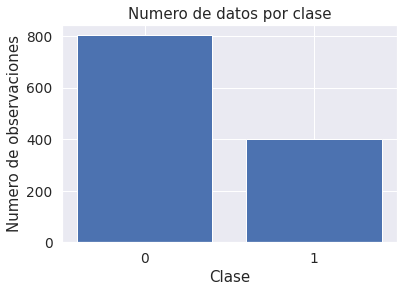

In [291]:
#@title Balance de clases con sobremuestreo { display-mode: "form" }
target= ['0', '1']
lista = [np.sum(y1==0),np.sum(y1==1)]
plt.bar(target, lista)
plt.title("Numero de datos por clase")
plt.xlabel("Clase")
plt.ylabel("Numero de observaciones");

Predictor: GaussianNB
Score en el cross_val_score:  0.851
Score en test:  0.8796680497925311
Score en entrenamiento 0.8753894080996885


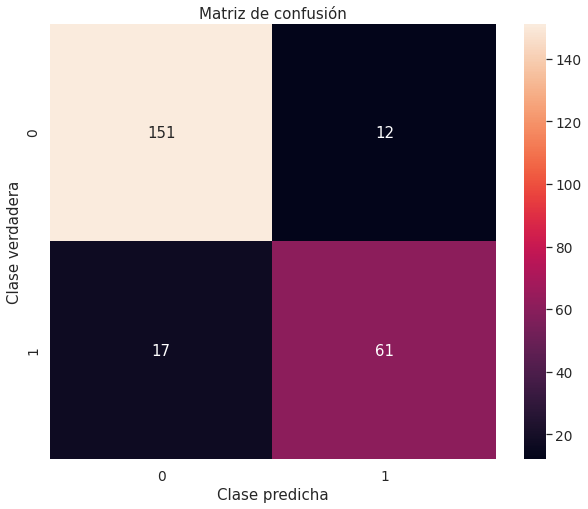

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       163
         1.0       0.84      0.78      0.81        78

    accuracy                           0.88       241
   macro avg       0.87      0.85      0.86       241
weighted avg       0.88      0.88      0.88       241




Predictor: DecisionTreeClassifier
Score en el cross_val_score:  0.9295
Score en test:  0.975103734439834
Score en entrenamiento 0.9854620976116303


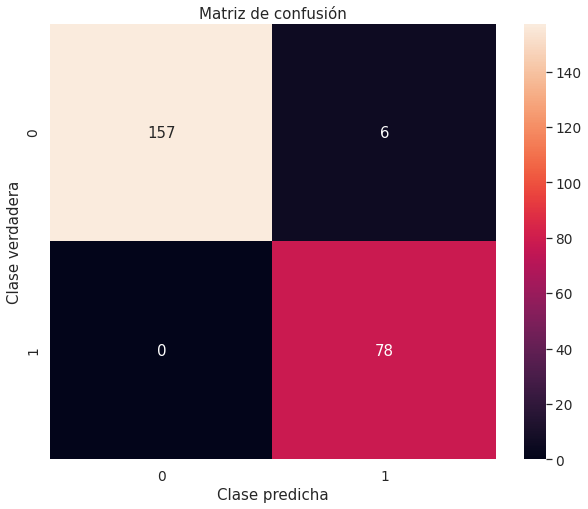

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       163
         1.0       0.93      1.00      0.96        78

    accuracy                           0.98       241
   macro avg       0.96      0.98      0.97       241
weighted avg       0.98      0.98      0.98       241




Predictor: RandomForestClassifier
Score en el cross_val_score:  0.9666666666666668
Score en test:  0.9875518672199171
Score en entrenamiento 0.9865005192107996


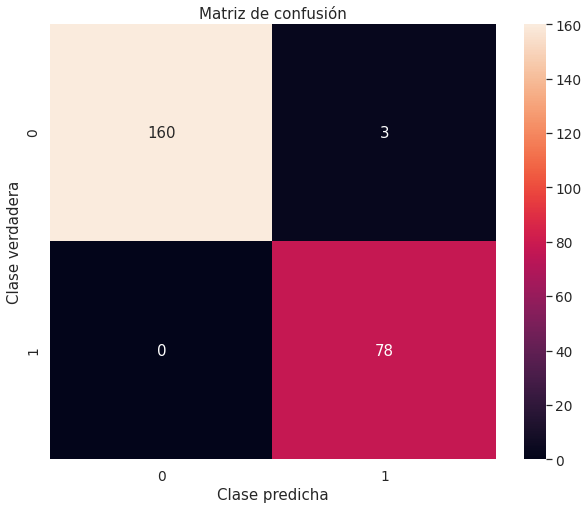

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       163
         1.0       0.96      1.00      0.98        78

    accuracy                           0.99       241
   macro avg       0.98      0.99      0.99       241
weighted avg       0.99      0.99      0.99       241




Predictor: SVC
Score en el cross_val_score:  0.9296666666666666
Score en test:  0.966804979253112
Score en entrenamiento 0.9553478712357217


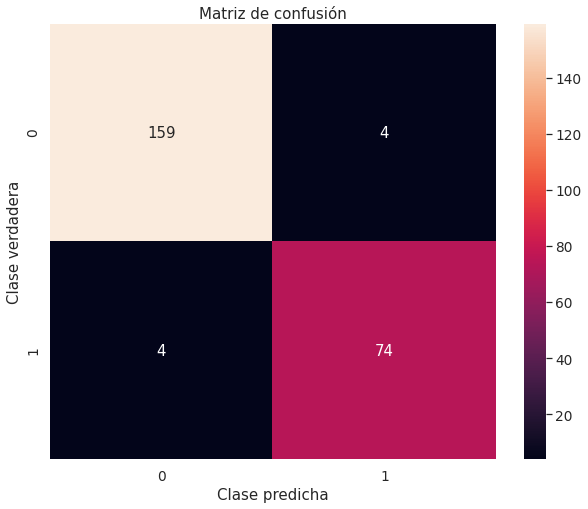

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       163
         1.0       0.95      0.95      0.95        78

    accuracy                           0.97       241
   macro avg       0.96      0.96      0.96       241
weighted avg       0.97      0.97      0.97       241






In [292]:
#@title Pruebas con los clasificadores { display-mode: "form" }
NB = GaussianNB() 
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced")
RF = RandomForestClassifier(n_estimators=64,max_depth=7,criterion="gini",class_weight="balanced")
SV= SVC(kernel='rbf',degree=3,gamma="scale",cache_size=300,class_weight="balanced")
predictores = ['GaussianNB','DecisionTreeClassifier','RandomForestClassifier','SVC']
PDs = [NB,DT,RF,SV]
scores = []
predict = []
for i,j in enumerate(PDs):
  PD,predic,score = run_model_MC(j,Xtrain,Xtest,ytrain,ytest,10)
  PDs[i] = PD
  predict.append(predic)
  scores.append(score)
  print("Predictor: {}".format(predictores[i]))
  print("Score en el cross_val_score: ",score)
  print("Score en test: ",PD.score(Xtest,ytest))
  print("Score en entrenamiento",PD.score(Xtrain,ytrain))
  matriz_confusion(ytest, predic)
  print("\n\n")

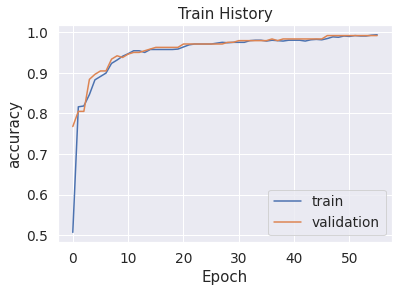

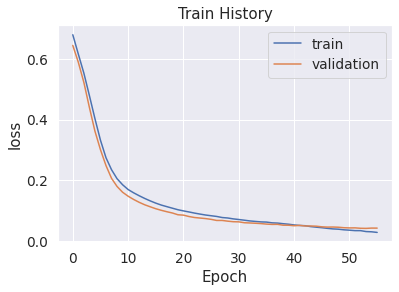

Test accuracy: 0.9917012453079224  test_loss:  0.041959814727306366


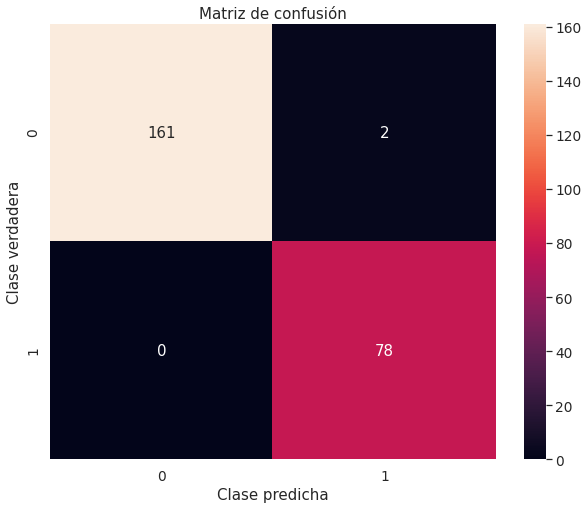

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       163
         1.0       0.97      1.00      0.99        78

    accuracy                           0.99       241
   macro avg       0.99      0.99      0.99       241
weighted avg       0.99      0.99      0.99       241



In [293]:
#@title Modelo de deep learning { display-mode: "form" }
y_train_ohe = tf.keras.utils.to_categorical(ytrain, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(ytest, num_classes=2)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= Xtrain[0].shape),
    tf.keras.layers.Dense(33, activation=tf.nn.relu),
    tf.keras.layers.Dense(28, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
#model.fit(Xtrain_pca, y_train_ohe, epochs=64,batch_size=100, validation_data=(Xtest_pca, y_test_ohe))
train_history = model.fit(x=Xtrain, y=y_train_ohe,  
                          validation_split=0, epochs=56, 
                          batch_size=172, verbose=0,validation_data=(Xtest, y_test_ohe)) 

#visualización de loss y accuracy por cada epoch
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

test_loss, test_acc = model.evaluate(Xtest, y_test_ohe, verbose=False)
print( 'Test accuracy:', test_acc, " test_loss: ", test_loss)
predictions = model.predict_classes(Xtest)
matriz_confusion(ytest, predictions)

##algo más